In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading results .csv

First, we open the csv

In [2]:
data = pd.read_csv("./experiment_stages.csv", index_col=0)

In [3]:
data

,arm_name,metric_name,mean,sem,trial_index
0,0_0,accuracy,0.795562,0.0,0
1,0_0,weight,0.701442,0.0,0
2,0_0,ram,0.703689,0.0,0
3,0_0,latency,0.600640,0.0,0
4,1_0,accuracy,0.706125,0.0,1
...,...,...,...,...,...
3515,898_0,latency,0.327915,0.0,898
3516,899_0,accuracy,0.598378,0.0,899
3517,899_0,weight,0.581171,0.0,899
3518,899_0,ram,0.546563,0.0,899


## Reoder by arm

We need to reorder it to be able to group different performances in one row and by arm

In [4]:
data_use = data.pivot(columns='metric_name', values='mean',
                         index='arm_name')

In [5]:
data_use

metric_name,accuracy,latency,ram,weight
arm_name,,,,
0_0,0.795562,0.600640,0.703689,0.701442
100_0,0.661357,0.452087,0.556115,0.591458
101_0,0.754984,0.572030,0.680436,0.683750
102_0,0.759577,0.667570,0.684806,0.715898
103_0,0.757547,0.528259,0.619019,0.657079
...,...,...,...,...
96_0,0.790015,0.639732,0.720727,0.722822
97_0,0.767722,0.732089,0.689055,0.712722
98_0,0.722385,0.493155,0.607247,0.639543


## DeStandardize

As we can see results are grouped by arm but we have a problem, they are still in relative values. SpArSeMoD uses sntardardizers internally to place the performance metrics in the same range (approx [0, 1]). To ungroup them we must know the standardization procedure, which is 

$$
standardized value = \frac{\log(real value)}{\log(standardization value)}
$$

where the standardization value depends on the metric.

+ Model Size: $10^8$
+ Working memory $10^8$
+ Latency $10^4$

Hence to recover the original value we have to isolate the real value in the last equation and we will obtain real values for all these metrics. Accuracy has no standardization. With this we will recover the number of parameters.

Then depending that we consider if 8 bit data types or 32-float, we will use a different conversion.

In the case or model size ('weight') and working memory ('ram'), we can proceed to suppose that they are 8-bit parameters and convert them to kilobytes, by dividing by 1024.



In [6]:
data_use['real_weight'] = np.exp(data_use['weight']*np.log(10**8))*8/8/1024
data_use['real_ram'] = np.exp(data_use['ram']*np.log(10**8))*8/8/1024
data_use['real_latency'] = np.exp(data_use['latency']*np.log(10**4) + 1)

In [7]:
data_use

metric_name,accuracy,latency,ram,weight,real_weight,real_ram,real_latency
arm_name,,,,,,,
0_0,0.795562,0.600640,0.703689,0.701442,399.244141,416.117188,686.835201
100_0,0.661357,0.452087,0.556115,0.591458,52.645508,27.455078,174.840703
101_0,0.754984,0.572030,0.680436,0.683750,288.205078,271.136719,527.732875
102_0,0.759577,0.667570,0.684806,0.715898,521.052734,293.867187,1272.259462
103_0,0.757547,0.528259,0.619019,0.657079,176.331055,87.467773,352.640357
...,...,...,...,...,...,...,...
96_0,0.790015,0.639732,0.720727,0.722822,591.936523,569.524414,984.514618
97_0,0.767722,0.732089,0.689055,0.712722,491.443359,317.789063,2304.890761
98_0,0.722385,0.493155,0.607247,0.639543,127.656250,70.416992,255.220262


## Pareto frontier

However, now we have all the result most of them do not interest us, since we only want the Pareto front. For this we have thw following function, that returns the pareto front

In [8]:
from sparsemod.heir import is_pareto_efficient

In [9]:
pareto_mask = is_pareto_efficient(data_use.values)
pareto_arms = data_use.index[pareto_mask].values

We then sort the vlaues, for example, by accuracy

In [4]:
data_use[pareto_mask].sort_values(by ='error')

NameError: name 'data_use' is not defined

Where we can see that the best model has a total accuracy of accuracy = (1- error) = 1 - 0.441 = 0.559, a model sie of 112KB in 8-bit vlaues, a RAM of 72 KB and a latency of 221 ms.

### Pareto Front and evolution

We can visualize the frontier obtained by Sparse

In [3]:
plt.figure(figsize=(10,6))
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(1-data_use[pareto_mask].sort_values(by ='accuracy')['accuracy'],
         data_use[pareto_mask].sort_values(by ='accuracy')['real_weight'],
           c=data_use[pareto_mask].sort_values(by ='accuracy')['real_ram'], s=40, cmap=cm)



cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(" RAM (KB)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Model Size (KB)", fontsize=25, fontfamily='serif')
plt.xlabel("Accuracy", fontsize=25, fontfamily='serif')


NameError: name 'data_use' is not defined

as well as the evolution

Text(0.5, 0, 'Accuracy')

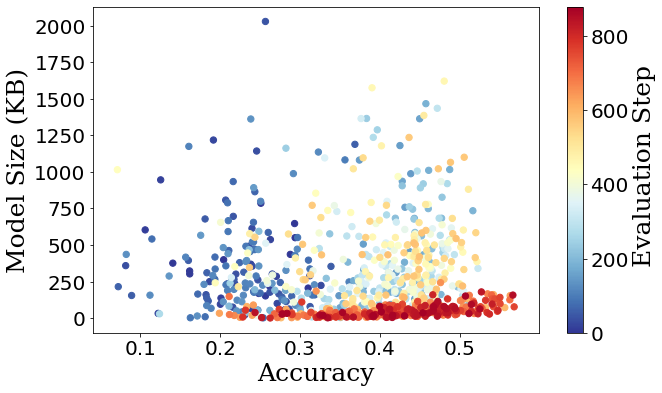

In [12]:
data_use['arm'] = data_use.index
data_use['arm'] = data_use['arm'].apply(lambda x: int(x.split("_")[0]))
data_use.sort_values(by='arm')

plt.figure(figsize=(10,6))
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(1 - data_use.sort_values(by='arm')['accuracy'],
         data_use.sort_values(by='arm')['real_weight'],
           c=range(len(data_use.sort_values(by='arm'))), s=40, cmap=cm)



cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(" Evaluation Step", fontsize=25, fontfamily='serif')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Model Size (KB)", fontsize=25, fontfamily='serif')
plt.xlabel("Accuracy", fontsize=25, fontfamily='serif')


# Inspecting an arm

In the performance lookup we saw that the bet arm was `749_0`. As we want the specific configuration to build the network we need to observe the specific parameters. For this we have to load a Sparse experiment. in `./cnn_cost_example/read_experiment/` a function has been built for that purpose

In [13]:
from read_experiment import load_experiment

[('__call__', <function LevelMapper.__call__ at 0x7fbe43643c20>), ('__init__', <function LevelMapper.__init__ at 0x7fbe43643b90>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7fbe435924d0>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7fbe43592440>)]
[('__init__', <function BoxCoder.__init__ at 0x7fbe43599cb0>), ('decode', <function BoxCoder.decode at 0x7fbe43599e60>), ('decode_single', <function BoxCoder.decode_single at 0x7fbe43599ef0>), ('encode', <function BoxCoder.encode at 0x7fbe43599d40>), ('encode_single', <function BoxCoder.encode_single at 0x7fbe43599dd0>)]
[('__call__', <function Matcher.__call__ at 0x7fbe43599c20>), ('__init__', <function Matcher.__init__ at 0x7fbe43599a70>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7fbe43599b90>)]
[('__init__', <function ImageList.__init__ at 0x7fbe4358f050>), ('to', <function ImageList.to at 0x7fbe4358f0e0>)]
[('__init__', <function Timebase.__init__ at

In [14]:
exp, data = load_experiment(data_folder="../data/data_cost/files")

AttributeError: 'SparseExperiment' object has no attribute 'cuda'

In [ ]:
exp.arms_by_name['779_0']